# Face cell response simulations

Written July 2022 by CMH

To generate more realistic neural responses that give us acess to the tuning structure of individual neurons, I am trying an alternative approach to simulating neural responses. The steps/logic are as follows: 

1. Define an arbitrary number of stimulus features and constraints on their values. This could be replaced with something like eigenface values, but for now they do not map onto actual stimuli.

2. Simulate n IT neurons with randomized weights. 

3. Generate a random feature vector and simulate the resopnse of the population as a linear combination of weighted features for each neuron. For the multiplexed data, we feed each neuron a different feature vector that has n% of features from stimulus A and n% from stimulus B. This simulates the multiplexing with some units responding as though to stimulus A and others responding as though to stimulus B.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance

def rectifying_nonlinearity(resp):
    for i in range(0, len(resp)):
        if resp[i] < 0:
            resp[i] = 0
    return resp

Download the LFW faces dataset to decompose to a set of features for face space.

In [84]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=20) # want to maximize number of faces
# print(faces.target_names)
print(faces.images.shape)


(3023, 62, 47)


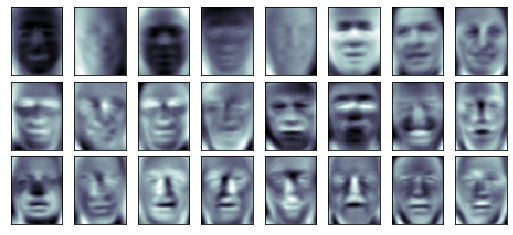

In [85]:
pca = PCA(100, svd_solver='randomized') # bring to 100 components 
pca.fit(faces.data)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

In [86]:
components = pca.transform(faces.data)

print(components.shape)

(3023, 100)


(array([343.,  47.,  48.,  22.,  15.,  13.,   7.,   3.,   0.,   2.]),
 array([ 0.        ,  6.10719132, 12.21438264, 18.32157396, 24.42876529,
        30.53595661, 36.64314793, 42.75033925, 48.85753057, 54.96472189,
        61.07191321]),
 <a list of 10 Patch objects>)

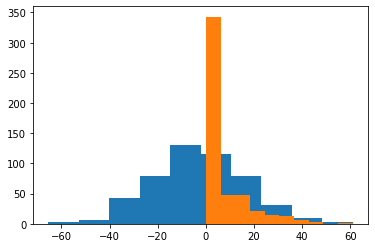

In [87]:
num_neurons = 500;
num_features = 100; # based on 100-dimensional face space in Chang & Tsao

# Simulate random feature weights for each neuron
W = np.empty((num_neurons, num_features))
for i in range(num_neurons):
    W[i, :] = np.random.normal(-0.01, 0.01, (1, num_features))

im1 = np.random.normal(0.5, 1, (1, num_features))
resp_im1 = components[0] @ W.T
plt.hist(resp_im1.T)
resp_im1 = rectifying_nonlinearity(resp_im1.reshape(num_neurons,))
plt.hist(resp_im1)

(array([ 879480., 1820364., 3173269., 5027681., 7075169., 7977569.,
        7073491., 4026228., 1242884.,  264827.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ], dtype=float32),
 <a list of 10 Patch objects>)

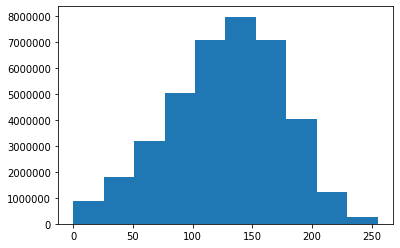

In [69]:
plt.hist(faces.data.ravel())

In [81]:
print(faces.data[0].shape)
print(faces.data.shape)
print(faces.target_names.shape)

(2914,)
(13233, 2914)
(5749,)


In [118]:
a = components[faces.target==0, :]
a = a[0:32, :]
b = components[faces.target==3, :]
b = b[0:32, :]

print(a.shape)
print(b.shape)

print(np.degrees(np.arccos(1-distance.cosine(a[0, :], b[0, :]))))

(32, 100)
(32, 100)
84.55886050600498


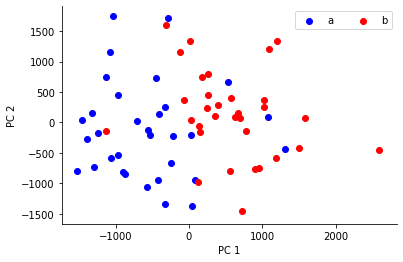

In [119]:
labels = np.concatenate((np.zeros((1, 32)), np.zeros((1, 32))+1), axis=0)
all_resp = np.concatenate((a, b), axis=0)

# Fit PCA model from sklearn
pca = PCA(n_components=2)
pca.fit(all_resp)
pc_activations = pca.transform(all_resp)

# Plot for visualization
fig, ax = plt.subplots()
c_resp = ['b', 'r']
f_labels = ['a', 'b']

for i in range(0, 2):
    ax.scatter(pc_activations[(labels==i).reshape(32*2,), 0], pc_activations[(labels==i).reshape(32*2,), 1], c=c_resp[i], label=f_labels[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=3)
plt.show()
